In [ ]:
!pip install transformers
!pip install kaggle
!pip install 'fsspec>=0.3.3'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 2.2 MB/s 
     |████████████████████████████████| 86 kB 5.0 MB/s 
     |████████████████████████████████| 596 kB 50.9 MB/s 
     |████████████████████████████████| 6.6 MB 27.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 4.3 MB/s 


In [ ]:
import re
import json
import itertools
import scipy as sp
import numpy as np
import pandas as pd
import dask.bag as db
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import accuracy_score, roc_curve, auc, hamming_loss
from sklearn import datasets
import scipy.cluster.hierarchy as hcluster
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
import jieba as jb
import tensorflow as tf
import torch

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. Setup

In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


# 2. Load arXiv Dataset

In [ ]:
import json
token = {"username":"karinmao","key":"0145306b9df944a40f90e51f15167f9c"}
with open('/content/kaggle.json','w') as file:
  json.dump(token,file)

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content
!kaggle datasets download -d Cornell-University/arxiv
!unzip -uq "/content/datasets/Cornell-University/arxiv/arxiv.zip" -d "/content/datasets/Cornell-University/arxiv"

- path is now set to: /content
 99% 1.03G/1.05G [00:43<00:00, 32.6MB/s]
100% 1.05G/1.05G [00:43<00:00, 26.1MB/s]


In [ ]:
# load data
docs = db.read_text('/content/datasets/Cornell-University/arxiv/arxiv-metadata-oai-snapshot.json').map(json.loads)

In [ ]:
# define target year
year = 1991

# Submissions by datetime
get_year = lambda x: x['versions'][-1]['created'].split(' ')[3]

# get only necessary fields
trim = lambda x: {'id': x['id'],
                  'title': x['title'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],
                  'time':x['versions'][-1]['created'].split(' ')[3]}

# filter for papers published on or after ????-01-01
docs_df = (docs.filter(lambda x: int(get_year(x)) > (year-1))
               .filter(lambda x: int(get_year(x)) < (year+1))
               .map(trim)
               .compute())

# convert to pandas dataframe
docs_df = pd.DataFrame(docs_df)

# add main category: list
docs_df['main_category'] = docs_df.category.apply(lambda x:[a.split('.')[0] for a in x][0].split())

# add main category 2: not list
docs_df['main_category2'] = docs_df.main_category.apply(lambda x: x[0])

In [ ]:
docs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              340 non-null    object
 1   title           340 non-null    object
 2   category        340 non-null    object
 3   abstract        340 non-null    object
 4   time            340 non-null    object
 5   main_category   340 non-null    object
 6   main_category2  340 non-null    object
dtypes: object(7)
memory usage: 18.7+ KB


In [ ]:
dict = {'astro-ph': 9, 'cond-mat': 3, 'cs': 6, 'econ': 16, 'eess': 18, 'funct-an': 20, 'gr-qc': 11, 'hep-ex': 19, 'hep-lat': 15,
 'hep-ph': 1,'hep-th': 4, 'math': 0, 'math-ph': 7, 'nlin': 10, 'nucl-ex': 12, 'nucl-th': 17, 'physics': 2, 'q-alg': 21,
 'q-bio': 13, 'q-fin': 14, 'quant-ph': 5, 'stat': 8, 'alg-geom':22}

dict2 = {'astro-ph': 9, 'cond-mat': 3, 'cs': 6, 'econ': 16, 'eess': 18, 'gr-qc': 11, 'hep-ex': 19, 'hep-lat': 15,
 'hep-ph': 1,'hep-th': 4, 'math': 0, 'math-ph': 7, 'nlin': 10, 'nucl-ex': 12, 'nucl-th': 17, 'physics': 2,
 'q-bio': 13, 'q-fin': 14, 'quant-ph': 5, 'stat': 8}

iv_dict = {v: k for k, v in dict.items()}

In [ ]:
# remove patterns
pattern = u'[\\s\\d,.<>/?:;\'\"[\\]{}()\\|~!\t"@#$%^&*\\-_=+\n《》、？：；“”‘’｛}（）…￥！—┄－]+'
docs_df['cut'] = (docs_df['abstract']
                    .apply(lambda x: str(x))
                    .apply(lambda x: re.sub(pattern, ' ', x)))
# define stopwords
stopwords = nltk.corpus.stopwords.words("english")

# remove stopwords
docs_df['cut2'] = docs_df['cut'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))

In [ ]:
docs_df.head()

,id,title,category,abstract,time,main_category,main_category2,cut,cut2
0,cs/9301113,Textbook examples of recursion,[cs.CC],We discuss properties of recursive schemas r...,1991,[cs],cs,We discuss properties of recursive schemas re...,We discuss properties recursive sc...
1,cs/9301114,Theory and practice,[cs.GL],The author argues to Silicon Valley that the...,1991,[cs],cs,The author argues to Silicon Valley that the ...,The author argues Silicon Valley ...
2,cs/9301115,Context-free multilanguages,[cs.DS],This article is a sketch of ideas that were ...,1991,[cs],cs,This article is a sketch of ideas that were o...,This article sketch ideas ...
3,hep-th/9108001,Exact Black String Solutions in Three Dimensions,[hep-th],A family of exact conformal field theories i...,1991,[hep-th],hep-th,A family of exact conformal field theories is...,A family exact conformal field t...
4,hep-th/9108002,Hamiltonian construction of W-gravity actions,[hep-th],We show that all W-gravity actions can be ea...,1991,[hep-th],hep-th,We show that all W gravity actions can be eas...,We show W gravity actions ...


Text(0.5, 1.0, 'year = 1991')

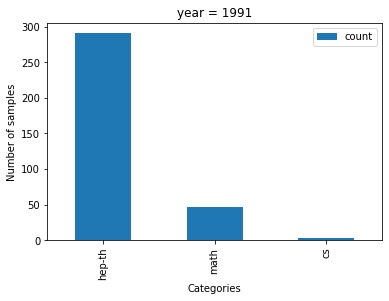

In [ ]:
d = {'cat':docs_df['main_category2'].value_counts().index, 'count': docs_df['main_category2'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
num_labels = len(df_cat)
# plot samples - categories
df_cat.plot('cat','count',kind='bar')
plt.xlabel('Categories')
plt.ylabel('Number of samples')
plt.title('year = %s'%(year))

In [ ]:
id_list = df_cat['cat'].map(dict).dropna(axis=0,how='any').tolist()
cat_list = df_cat['cat'].map(dict).dropna(axis=0,how='any').map(iv_dict).tolist()
cat_list

['hep-th', 'math', 'cs']

In [ ]:
# cat tansfer to id
docs_df['cat_id'] = docs_df['main_category2'].map(dict)

In [ ]:
docs_df.head()

,id,title,category,abstract,time,main_category,main_category2,cut,cut2,cat_id
0,cs/9301113,Textbook examples of recursion,[cs.CC],We discuss properties of recursive schemas r...,1991,[cs],cs,We discuss properties of recursive schemas re...,We discuss properties recursive sc...,6
1,cs/9301114,Theory and practice,[cs.GL],The author argues to Silicon Valley that the...,1991,[cs],cs,The author argues to Silicon Valley that the ...,The author argues Silicon Valley ...,6
2,cs/9301115,Context-free multilanguages,[cs.DS],This article is a sketch of ideas that were ...,1991,[cs],cs,This article is a sketch of ideas that were o...,This article sketch ideas ...,6
3,hep-th/9108001,Exact Black String Solutions in Three Dimensions,[hep-th],A family of exact conformal field theories i...,1991,[hep-th],hep-th,A family of exact conformal field theories is...,A family exact conformal field t...,4
4,hep-th/9108002,Hamiltonian construction of W-gravity actions,[hep-th],We show that all W-gravity actions can be ea...,1991,[hep-th],hep-th,We show that all W gravity actions can be eas...,We show W gravity actions ...,4


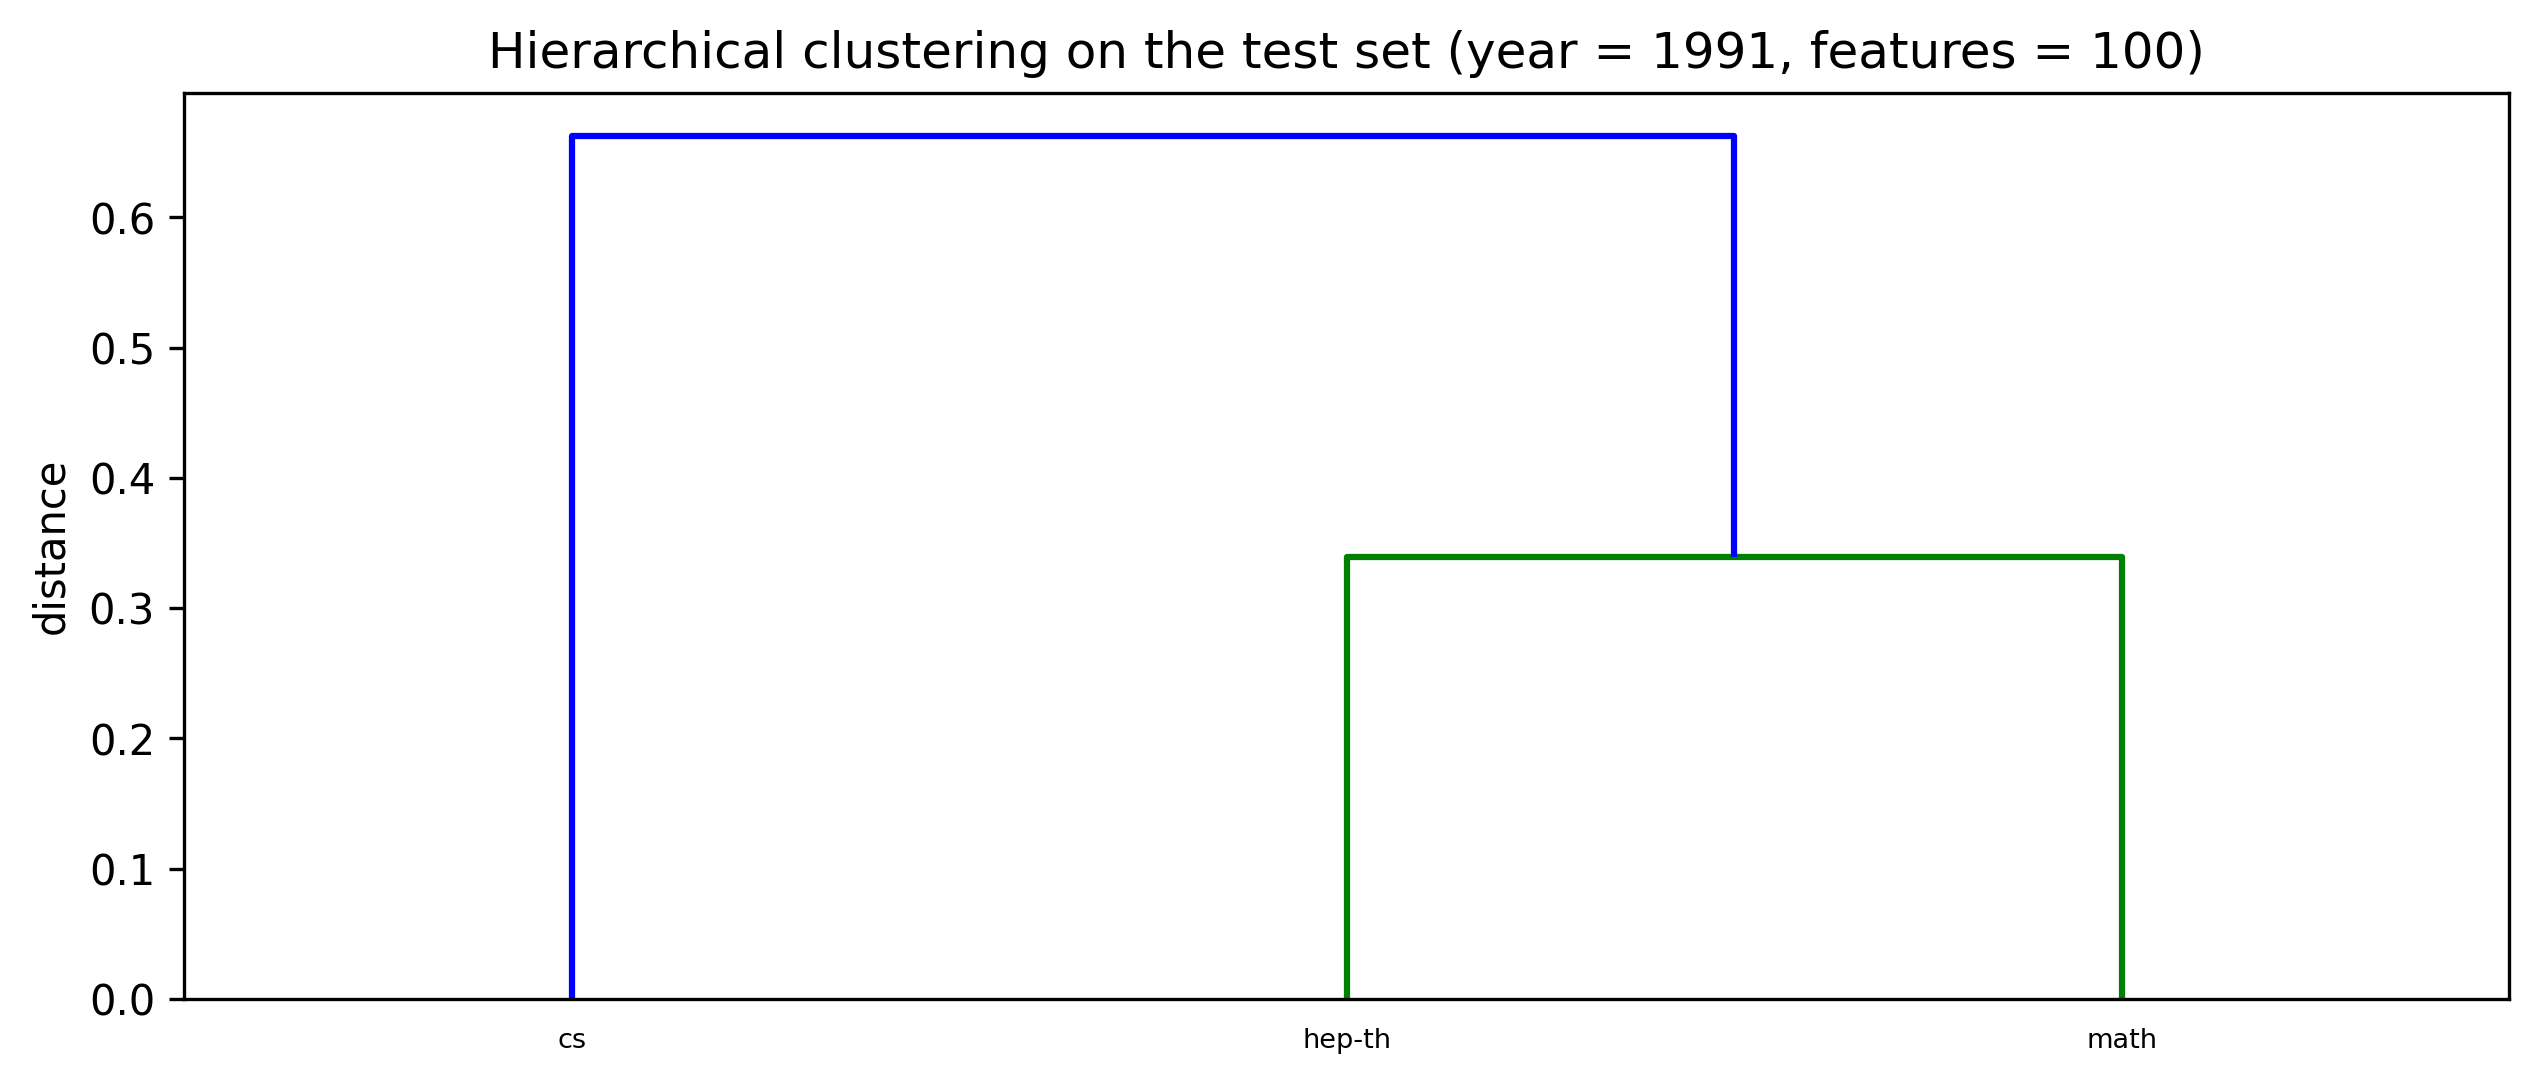

In [ ]:
def Hierarchical_clustering(year, docs_df, corpus, features):

    tr_ = TfidfVectorizer(max_features = features)
    tfidf = tr_.fit_transform(corpus).toarray()

    names = locals()
    for i in id_list:
        names['tfidf_' + str(i) ] = np.mean(tfidf[docs_df[docs_df['cat_id'] == i].index],axis=0)
        if i == id_list[0]:
            dis_mat = names['tfidf_' + str(i) ]
        if i != id_list[0]:
            dis_mat = np.vstack((dis_mat, names['tfidf_' + str(i) ]))

    frame = pd.DataFrame(dis_mat, index = cat_list)

    # Compute and plot first dendrogram.
    plt.figure(figsize=(10, 4), dpi=300)
    linkage = hcluster.linkage(dis_mat, method ='ward', metric='euclidean')
    hcluster.dendrogram(linkage,  leaf_font_size=6.5,labels=frame.index)
    p = hcluster.fcluster(linkage, 10, criterion='maxclust')
    plt.title('Hierarchical clustering on the test set (year = %s, features = %s)'%(year, features))
    plt.ylabel('distance')

Hierarchical_clustering(year, docs_df, docs_df['cut2'], 100)
